In [1]:
# Your Name: Conor Apcar
# Your Student ID: 44624336

# Online Retail Customer Clustering

This exercise uses a dataset containing records of online retail transactions. The data is available at [The UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/Online+Retail).  

The goal of the exercise is to use clustering techniques to idenfity customer segments in the data that might be suitable for targetted marketing or market research.   There is a discussion of this along with an example analysis (in R) [in this blog post](http://www.kimberlycoffey.com/blog/2016/8/k-means-clustering-for-customer-segmentation).   Your task is to reproduce this in Python and comment on the results that you observe.

The data is available as a spreadsheet, I've saved this as a CSV file.   I've written some code below to read 
the data and to add some derived columns to the data frame.  I've done this, rather than ask you to do it, 
because it was fairly tricky to find out how to do this and uses groupby and aggregate functions that we've not
covered much.  Take this as an example of data preparation.


In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pylab as plt
from sklearn import cluster
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
%matplotlib inline

retail = pd.read_csv('files/online-retail.csv')
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,1/12/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,1/12/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/10 8:26,3.39,17850.0,United Kingdom


Went through and checked the data for outliers, and any data that needed to be cleaned. First noticed was the high and lowe min and max  with a mean no where near either. 
Looking at a scatter plot for both quantity and unit price we can see that there are a couple of points that are strethcing out the data and need to be removed.
Also remove any empty values before restricting the size of both quantity and unit price to between -10000 and 10000. I do this since it gets rid of the really high outliers however on the new scatter plots we can see a better spread but still with a lot of the data hovering around that 0 mark.
I felt I couldn't remove more since this is to do with customers spending and it is important to still look and people who buy a lot more and spend a lot more than most people seem to do.

Also limited the data to one year and one country being the UK similar to what was done in the blog to help clean it a little better, and it can show spending habits of people only in the UK which for a marketing company can help with specific promotions driven for England.

In [3]:
retail.shape #Check shape of dataframe

(541909, 8)

In [4]:
retail.describe() #describe the dataframe

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


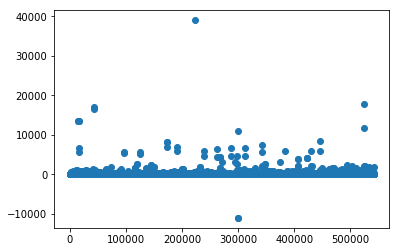

In [5]:
plt.scatter(retail.index, retail['UnitPrice']) #Plot the UnitPrice check for outliers

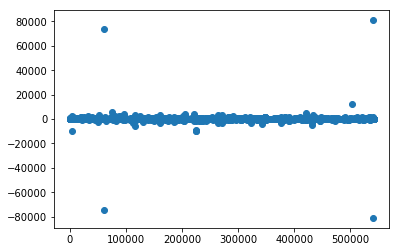

In [6]:
plt.scatter(retail.index, retail['Quantity']) #Plot the Quantity check for outliers

In [7]:
retail.dropna(inplace=True) #Drop all data that is empty
retail.shape

(406829, 8)

(406828, 8)


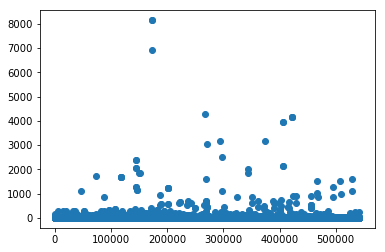

In [8]:
#Restrict the UnitPrice to certain size to get rid of outliers and create better clusters
retail = retail.drop(retail.index[retail['UnitPrice'] <= -10000])
retail = retail.drop(retail.index[retail['UnitPrice'] > 10000])
print(retail.shape)
plt.scatter(retail.index, retail['UnitPrice'])

(406823, 8)


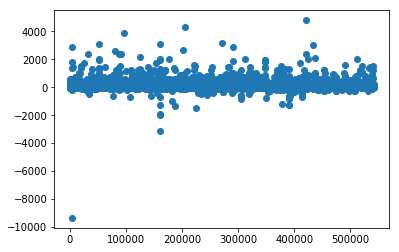

In [9]:
#Restrict the Quantity to certain size to get rid of outliers and create better clusters
retail = retail.drop(retail.index[retail['Quantity'] <= -10000])
retail = retail.drop(retail.index[retail['Quantity']  > 10000])
print(retail.shape)
plt.scatter(retail.index, retail['Quantity'])

In [10]:
#Change InvoiceDate into 'datetime' to help limit dataset
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom


In [11]:
#Limit dataframe to 1 year
retail = retail[retail['InvoiceDate'] >= '2010-09-12']
#Restrict the country to the UK
retail = retail[retail['Country'] == 'United Kingdom']
retail.shape

(349800, 8)

In [12]:
retail.describe() #Check how the data looks now

,Quantity,UnitPrice,CustomerID
count,349800.000000,349800.000000,349800.000000
mean,11.095117,3.148853,15539.145718
std,43.024138,28.678303,1591.325859
min,-3114.000000,0.000000,12747.000000
25%,2.000000,1.250000,14189.000000
50%,4.000000,1.950000,15505.000000
75%,12.000000,3.750000,16923.000000
max,4800.000000,8142.750000,18287.000000


In [13]:
# add a column 'value' for the value of each transaction
retail = retail.assign(value=retail.Quantity * retail.UnitPrice)

# split into returns and sales, returns have a quantity less than zero
returns = retail.loc[retail.Quantity<=0]
sales = retail.loc[retail.Quantity>0]
print("Sales", sales.shape)
print("Returns", returns.shape)

Sales (342475, 9)
Returns (7325, 9)


## Adding Columns

This next step turns the data into a dataframe with customers as the index and aggregates the numerical columns using the mean.  So we get the mean quantity, price and value of transactions for this customer.  I also add a count of the number of transactions per customer. 

You should experiment with the groupby and aggregate methods, they're very useful.

In [14]:
sales_grouped = sales[['CustomerID', 'Quantity', 'UnitPrice', 'value']].groupby('CustomerID').aggregate(np.mean)

# add a count of the number of invoices (== frequency in referenced analysis)
counts = sales.groupby('CustomerID').size().to_frame(name='count')
sales_grouped = sales_grouped.join(counts)

sales_grouped.head()

,Quantity,UnitPrice,value,count
CustomerID,,,,
12747.0,12.156250,4.466250,39.973438,96
12748.0,5.773736,2.701308,7.523519,4234
12749.0,7.391960,4.999950,20.557186,199
12820.0,12.237288,1.904746,15.971864,59
12821.0,11.666667,2.498333,15.453333,6


This next step computes the time from each invoice date to the most recent invoice date and converts it to days. The following step then aggregates this per customer using *max* to get the most recent invoice per customer.  This is then added to the *sales_grouped* dataframe. 

In [15]:
# add recency of purchases
# this takes some time to compute
#Flipped the two values around so I would have positive values for recency for the log
recency = pd.to_datetime("2011-12-10") - pd.to_datetime(sales.InvoiceDate)
# get just the number of days so that we can use this value in clustering
recency = recency.apply(lambda x: x.days)

In [16]:
# turn recency into a dataframe with the customerID column from sales
recency_df = sales[['CustomerID']].assign(recency=recency)
# aggregate recency using max to get the most recent sale per customer
grp = recency_df[['CustomerID', 'recency']].groupby('CustomerID').aggregate(np.max)

# customers is our final dataframe of customer data 
customers = sales_grouped.join(grp)
customers.head()

,Quantity,UnitPrice,value,count,recency
CustomerID,,,,,
12747.0,12.156250,4.466250,39.973438,96,361
12748.0,5.773736,2.701308,7.523519,4234,453
12749.0,7.391960,4.999950,20.557186,199,335
12820.0,12.237288,1.904746,15.971864,59,326
12821.0,11.666667,2.498333,15.453333,6,95


## Your Analysis

You now have a data frame of customer data with various columns computed from the original data.  Your task now is to find meaningful clusters in this data to give to the marketing team.  

- select a clustering algorithm and it's parameters, justify your choice
- cluster the data, evaluate the number of clusters
- visualise your results in one or more ways
- provide an interpretation of the resulting clusters - are there clusters that might be of interest to marketing? What characterises these customers? 

Before doing the clustering, I went through and checked customers and the new columns for outliers that i should remove that would effect the clustering, as we would see all the data in one cluster with one or two others by themeselves in another.

Also normalised the data with a logarithm, I had to swap around the recency values so that it would work with recency as well.

Will put both through a clustering techniques to see any difference.

In [17]:
#Check the shape and head of customers
print(customers.shape)
customers.head()

(3861, 5)


,Quantity,UnitPrice,value,count,recency
CustomerID,,,,,
12747.0,12.156250,4.466250,39.973438,96,361
12748.0,5.773736,2.701308,7.523519,4234,453
12749.0,7.391960,4.999950,20.557186,199,335
12820.0,12.237288,1.904746,15.971864,59,326
12821.0,11.666667,2.498333,15.453333,6,95


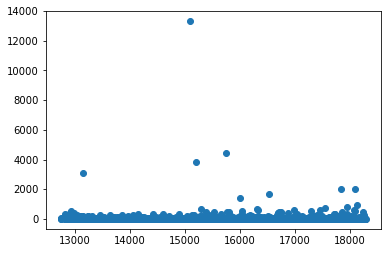

In [18]:
#Check for outliers in value
plt.scatter(customers.index, customers['value'])

(3860, 5)


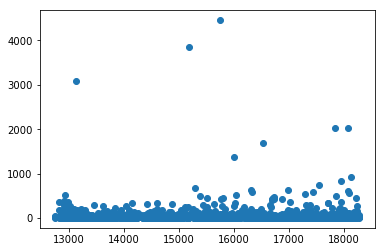

In [19]:
#Remove outliers from value
customers = customers.drop(customers.index[customers['value'] > 10000]) 
print(customers.shape)
#Check that data looks better
plt.scatter(customers.index, customers['value'])

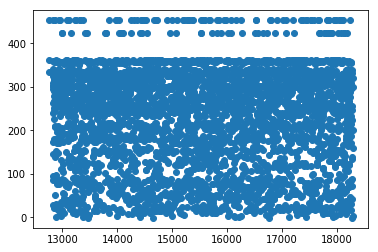

In [20]:
#Check for outliers in recency
plt.scatter(customers.index, customers['recency'])

In [21]:
#Run a log on the data to normalise
customersLog = np.log10(customers)
#Remove all empty and invalid values
customersLog.replace([np.inf, -np.inf], np.nan)
customersLog.dropna(inplace=True)
customersLog = customersLog[~customersLog.isin([np.nan, np.inf, -np.inf]).any(1)]
customersLog.head()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


,Quantity,UnitPrice,value,count,recency
CustomerID,,,,,
12747.0,1.084800,0.649943,1.601771,1.982271,2.557507
12748.0,0.761457,0.431574,0.876421,3.626751,2.656098
12749.0,0.868760,0.698966,1.312964,2.298853,2.525045
12820.0,1.087685,0.279837,1.203356,1.770852,2.513218
12821.0,1.066947,0.397650,1.189022,0.778151,1.977724


In [22]:
customersLog.describe()

,Quantity,UnitPrice,value,count,recency
count,3850.000000,3850.000000,3850.000000,3850.000000,3850.000000
mean,0.988472,0.455038,1.247740,1.587715,2.258755
std,0.409100,0.240517,0.387450,0.575699,0.360557
min,0.000000,-0.911864,0.161368,0.000000,0.000000
25%,0.744493,0.330673,1.044238,1.230449,2.161368
50%,0.992639,0.452960,1.237724,1.602060,2.397940
75%,1.166331,0.571627,1.386658,1.991226,2.502427
max,3.633468,3.308159,3.648695,3.886885,2.656098


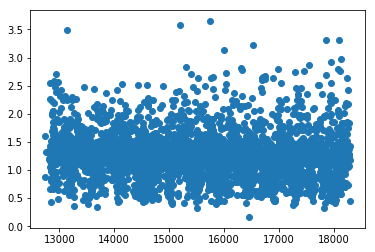

In [23]:
#Look at the plots of the normalised data
plt.scatter(customersLog.index, customersLog['value'])

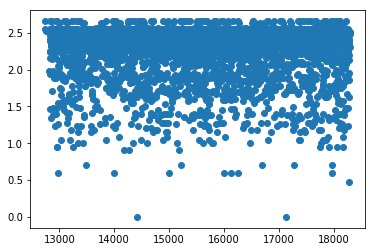

In [24]:
plt.scatter(customersLog.index, customersLog['recency'])

Put both the normalised and non-normalised through a kmeans cluster. I used k means clustering as i thought it was a best way to get an accurate output of different clusters.  I had previously tried other numbers of clusters for both but settled that 3 clusters was the best and gave an accurate representation of the data. after looking at the amount of points in each cluster.

In [25]:
#Run a kmeans clustering with a total of 3 clusters for the non-normalised data first
nonStdCluster = cluster.KMeans(n_clusters = 3, init='k-means++', n_init = 50)
nonStdCluster.fit(customers)

labels = nonStdCluster.predict(customers)

print('Cluster 0: \n' + str([customers.index[i] for i,item in enumerate(labels) if item==0]))
print( '\n')
print('Cluster 1: \n' + str([customers.index[i] for i,item in enumerate(labels) if item==1]))
print( '\n')
print('Cluster 2: \n' + str([customers.index[i] for i,item in enumerate(labels) if item==2]))
print( '\n')

Cluster 0: 
[12747.0, 12749.0, 12820.0, 12821.0, 12822.0, 12823.0, 12824.0, 12826.0, 12827.0, 12828.0, 12829.0, 12830.0, 12831.0, 12832.0, 12833.0, 12834.0, 12836.0, 12837.0, 12838.0, 12839.0, 12840.0, 12841.0, 12842.0, 12843.0, 12844.0, 12845.0, 12847.0, 12849.0, 12851.0, 12852.0, 12853.0, 12854.0, 12856.0, 12857.0, 12863.0, 12864.0, 12867.0, 12868.0, 12871.0, 12872.0, 12873.0, 12875.0, 12877.0, 12878.0, 12879.0, 12881.0, 12882.0, 12883.0, 12884.0, 12885.0, 12886.0, 12888.0, 12890.0, 12891.0, 12893.0, 12895.0, 12897.0, 12901.0, 12902.0, 12904.0, 12906.0, 12908.0, 12909.0, 12910.0, 12912.0, 12913.0, 12915.0, 12916.0, 12917.0, 12919.0, 12920.0, 12921.0, 12922.0, 12923.0, 12924.0, 12925.0, 12928.0, 12929.0, 12930.0, 12931.0, 12933.0, 12935.0, 12936.0, 12937.0, 12938.0, 12939.0, 12940.0, 12942.0, 12944.0, 12945.0, 12947.0, 12948.0, 12949.0, 12950.0, 12951.0, 12952.0, 12953.0, 12955.0, 12956.0, 12957.0, 12962.0, 12963.0, 12965.0, 12966.0, 12967.0, 12968.0, 12970.0, 12971.0, 12974.0, 12976.

In [26]:
#Run the kmeans clustering on the normalised 
stdCluster = cluster.KMeans(n_clusters = 3, init='k-means++',)
stdCluster.fit(customersLog)

labels = stdCluster.predict(customersLog)

print('Cluster 0: \n' + str([customersLog.index[i] for i,item in enumerate(labels) if item==0]))
print( '\n')
print('Cluster 1: \n' + str([customersLog.index[i] for i,item in enumerate(labels) if item==1]))
print( '\n')
print('Cluster 2: \n' + str([customersLog.index[i] for i,item in enumerate(labels) if item==2]))
print( '\n')

Cluster 0: 
[12821.0, 12822.0, 12824.0, 12827.0, 12831.0, 12832.0, 12833.0, 12834.0, 12837.0, 12842.0, 12845.0, 12847.0, 12852.0, 12857.0, 12871.0, 12881.0, 12883.0, 12893.0, 12895.0, 12902.0, 12906.0, 12913.0, 12915.0, 12920.0, 12922.0, 12923.0, 12924.0, 12925.0, 12929.0, 12930.0, 12936.0, 12938.0, 12944.0, 12945.0, 12953.0, 12956.0, 12962.0, 12966.0, 12968.0, 12974.0, 12976.0, 12977.0, 12981.0, 12982.0, 12984.0, 12987.0, 12990.0, 12991.0, 12993.0, 12999.0, 13000.0, 13002.0, 13003.0, 13005.0, 13006.0, 13008.0, 13016.0, 13023.0, 13026.0, 13028.0, 13030.0, 13033.0, 13034.0, 13035.0, 13038.0, 13043.0, 13044.0, 13045.0, 13046.0, 13052.0, 13058.0, 13059.0, 13060.0, 13061.0, 13067.0, 13070.0, 13072.0, 13075.0, 13079.0, 13080.0, 13083.0, 13085.0, 13091.0, 13092.0, 13095.0, 13101.0, 13103.0, 13116.0, 13127.0, 13131.0, 13132.0, 13133.0, 13140.0, 13142.0, 13144.0, 13146.0, 13155.0, 13160.0, 13161.0, 13165.0, 13170.0, 13173.0, 13177.0, 13182.0, 13187.0, 13189.0, 13193.0, 13194.0, 13200.0, 13203.

Cluster 2: 
[12747.0, 12748.0, 12749.0, 12820.0, 12826.0, 12828.0, 12836.0, 12838.0, 12839.0, 12840.0, 12841.0, 12843.0, 12844.0, 12849.0, 12851.0, 12853.0, 12854.0, 12856.0, 12867.0, 12868.0, 12872.0, 12877.0, 12878.0, 12885.0, 12886.0, 12890.0, 12904.0, 12909.0, 12910.0, 12916.0, 12919.0, 12921.0, 12928.0, 12933.0, 12935.0, 12937.0, 12940.0, 12942.0, 12947.0, 12948.0, 12949.0, 12951.0, 12952.0, 12955.0, 12957.0, 12963.0, 12965.0, 12970.0, 12971.0, 12985.0, 12988.0, 12994.0, 12997.0, 13001.0, 13004.0, 13012.0, 13013.0, 13014.0, 13015.0, 13018.0, 13021.0, 13032.0, 13037.0, 13040.0, 13047.0, 13048.0, 13050.0, 13055.0, 13064.0, 13066.0, 13069.0, 13077.0, 13078.0, 13081.0, 13089.0, 13090.0, 13093.0, 13097.0, 13098.0, 13102.0, 13107.0, 13109.0, 13110.0, 13113.0, 13115.0, 13117.0, 13118.0, 13121.0, 13122.0, 13124.0, 13126.0, 13134.0, 13136.0, 13137.0, 13138.0, 13139.0, 13141.0, 13148.0, 13149.0, 13151.0, 13157.0, 13158.0, 13159.0, 13162.0, 13166.0, 13167.0, 13168.0, 13171.0, 13174.0, 13176.

I used a Principal Component Analysis (PCA) in order to identify patterns on a smaller scale that is easier to visualise and interpret by reducing the dataset. This should reperesent the overall data well with minimal loss of information.

I gave a reference plot of the data to base the clustering off of, to check how well the labels predict and cluster the model.

I also describe each of the clusters to help interpet the visulaisations of the clusters, and see where the clusters are occuring.

I do this for bot the normalised and non-normalised data.

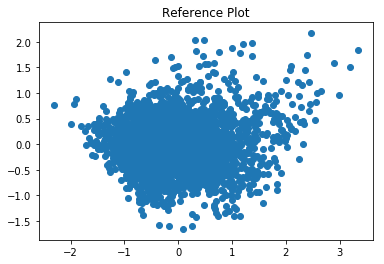

In [27]:
#Use a PCA to reduce the dimensions of the dataset into something that represents the overall data well
pca = PCA(n_components=2).fit(customersLog)
#First look at the normalised data
pca_2d = pca.transform(customersLog)
#Use this scatter plot as a reference for the clustering prediction
plt.title('Reference Plot')
plt.scatter(pca_2d[:, 0], pca_2d[:, 1])

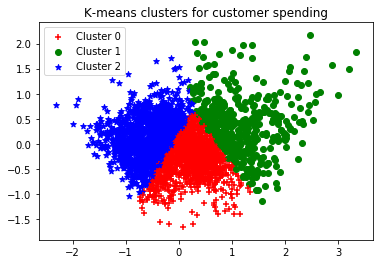

In [28]:
#Loop through each point in the dataframe
for i in range(0, customersLog.shape[0]):
    #If its label is a part of cluster 0, plot in red and as +
    if labels[i] == 0:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='+')
    #If its label is a part of cluster 1, plot in green and as o
    elif labels[i] == 1:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g', marker='o')
    #If its label is a part of cluster 2, plot in blue and as *
    elif labels[i] == 2:  
        c3 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b', marker='*')
plt.legend([c1, c2, c3],['Cluster 0', 'Cluster 1', 'Cluster 2'])
plt.title('K-means clusters for customer spending')
#Plot the clusters
plt.show()


In [29]:
#seperate each cluster and look at the mean values of each to see how they cluster
c0 = [ customersLog.index[i] for i,item in enumerate(labels) if item==0]
c1 = [ customersLog.index[i] for i,item in enumerate(labels) if item==1]
c2 = [ customersLog.index[i] for i,item in enumerate(labels) if item==2]
customersLog.loc[c0].describe()

,Quantity,UnitPrice,value,count,recency
count,1703.000000,1703.000000,1703.000000,1703.000000,1703.000000
mean,0.940605,0.478212,1.217050,1.273485,2.104025
std,0.278419,0.234513,0.232184,0.306474,0.419522
min,0.000000,-0.407020,0.161368,0.000000,0.000000
25%,0.812913,0.335517,1.148700,1.079181,1.857332
50%,0.985277,0.479876,1.238539,1.322219,2.255273
75%,1.111206,0.606991,1.337793,1.491362,2.425696
max,1.761552,2.469822,2.469822,1.959041,2.656098


In [30]:
customersLog.loc[c1].describe()

,Quantity,UnitPrice,value,count,recency
count,433.000000,433.000000,433.000000,433.000000,433.000000
mean,1.677668,0.435877,1.960525,0.872791,2.274871
std,0.484562,0.455995,0.393977,0.564835,0.328865
min,0.000000,-0.911864,1.064458,0.000000,0.903090
25%,1.385606,0.209962,1.709533,0.477121,2.127105
50%,1.605011,0.406540,1.882638,0.845098,2.403121
75%,1.857332,0.614792,2.165066,1.230449,2.502427
max,3.633468,3.308159,3.648695,2.617000,2.656098


In [31]:
customersLog.loc[c2].describe()

,Quantity,UnitPrice,value,count,recency
count,1714.000000,1714.000000,1714.000000,1714.000000,1714.000000
mean,0.861924,0.436854,1.098167,2.080537,2.408421
std,0.318516,0.148132,0.304714,0.317083,0.208999
min,0.024134,-0.178925,0.322485,1.447158,1.041393
25%,0.615064,0.344790,0.858423,1.838849,2.371068
50%,0.923290,0.439655,1.175460,2.025306,2.472756
75%,1.078012,0.525897,1.291286,2.267172,2.528917
max,2.044807,1.407010,2.174507,3.886885,2.656098


Overall we've ended up with three clusters.

Cluster 0 contains customers that have a resonably low value per transaction, and have a low count but seem to be making transaction more frequently than the other two clusters. We are able to see this as the count and frequency combined lower these points on the plot and the transactions keep it fairly central around the 0.

Cluster 1 contains customers that place the highest values per transaction which is indicated by the data being more to the right of the plot past the first cluster. We also can see a low count for the amount of transaction and it is also the lowest of the three but a fairly resonable recency of there transaction in terms of how long apart they spend between each. Together we see that they make slight more purchases. This is shown well on the plot with a lot of customers in the cluster 1 trending upward the y axis above the customers in cluster 0.

Cluster 2 contains customers that place a low value on there transaction, making it the lowest between all three clusters as indicated by the fact that these customers are the furthest to the left on the x axis. However a high count and recency shows that these customers make plenty of transactions, which is more that both other clusters, showing similar to cluster 1 on the y axis but above cluster 0.

Overall we can see that Cluster 0 had low value on there transaction and a low and a low amount of transactions as well, making them low spenders, low users. Cluster 1 had a high value on there transactions, but a low amount of transactions, making them  high spenders, low users. Cluster 2 placed a low value on there transactions, but were constantly making transactions making them, low spenders, high users.

This sort of information can be useful to a marketing company to see how there customers use there money. It is important to recognise that you aren't likely to make someone from cluster 0 buy in to whatever you are trying to sell them since they don't spend much or make many transactions.You should focus on the other two. with cluster 2 more likely to make lots of small transactions, and you can push for bigger and more expensive items onto customers from cluster 1.